In [116]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

In [117]:
from scipy import io

mat_file = io.loadmat('test_32x32.mat')

In [118]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:18:15 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[[[ 38, 129, 150, ..., 115,  96, 101],
          [103, 142, 160, ..., 132,  65,  75],
          [ 60, 153, 169, ..., 142,  47,  60]],
 
         [[ 39, 127, 150, ..., 116,  97, 100],
          [104, 143, 163, ..., 133,  65,  73],
          [ 61, 152, 170, ..., 143,  49,  60]],
 
         [[ 39, 125, 152, ..., 117,  97,  99],
          [104, 143, 168, ..., 134,  65,  71],
          [ 62, 151, 172, ..., 144,  50,  59]],
 
         ...,
 
         [[ 41, 121, 153, ..., 114,  86,  95],
          [102, 133, 172, ..., 136,  61,  63],
          [ 61, 153, 180, ..., 141,  54,  52]],
 
         [[ 42, 123, 150, ..., 114,  87,  95],
          [103, 134, 171, ..., 136,  62,  63],
          [ 62, 156, 181, ..., 142,  55,  52]],
 
         [[ 39, 123, 147, ..., 115,  88,  96],
          [ 97, 135, 169, ..., 136,  63,  64],
          [ 57, 157, 180, 

In [119]:
x = mat_file['X']
y = mat_file['y']

In [120]:
type(x)

numpy.ndarray

In [121]:
np.shape(x), np.shape(y), np.unique(y)

((32, 32, 3, 26032),
 (26032, 1),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

In [122]:
y[y == 10] = 0
print(np.unique(y))

[0 1 2 3 4 5 6 7 8 9]


x.shape을 보니 WHCN형태
(width, height, channel, n) -> (n, weight, height, channel)

In [123]:
_x = x.transpose((3,0,1,2)) # 3번째를 0번으로 0번째를 1번으로...
# _x = np.reshape(x, [-1, 32, 32, 3])
_y =y[:,0]
# _y = np.reshape(y, [1, -1])
_x.shape, _y.shape

((26032, 32, 32, 3), (26032,))

In [125]:
np.any(np.isnan(_x))

False

In [22]:
def plot_images(img, labels, nrows, ncols):
    '''
    nrows x ncols의 크기(형태)의 그래프 이미지
    '''
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat):
        if img[i].shape == (32, 32, 3): # 컬러
            ax.imshow(img[i])
        else:
            ax.imshow(img[i, :, :, 0]) # 흑백
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

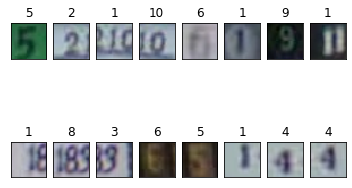

In [23]:
plot_images(_x, _y, 2, 8)

In [102]:
_x[:50].shape, _y[:50].shape, set(_y)

((50, 32, 32, 3), (50,), {1, 2, 3, 4, 5, 6, 7, 8, 9, 10})

In [103]:
_y[_y == 10] = 0
set(_y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [29]:
np.save('x', _x[:50])
np.save('y', _y[:50])

In [59]:
X_train = np.load('x.npy')
Y_train = np.load('y.npy')
X_train.shape, Y_train.shape, set(Y_train)

((50, 32, 32, 3), (50,), {1, 2, 3, 4, 5, 6, 8, 9, 10})

In [89]:
Y_train[Y_train == 10] = 0
print(np.unique(Y_train))

[0 1 2 3 4 5 6 8 9]


## Grayscale

In [53]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [54]:
X_gray = rgb2gray(X_train).astype(np.float32)
X_gray.shape

(50, 32, 32, 1)

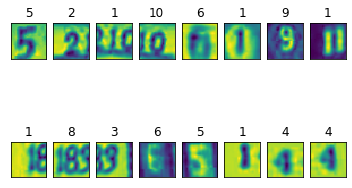

In [55]:
plot_images(X_gray, Y_train, 2, 8)

In [104]:
_x = rgb2gray(_x).astype(np.float32)
_x.shape

(26032, 32, 32, 1)

## Model

In [171]:
# CNN Model
class CNNModel(keras.Model):
    
    def __init__(self):    
        super(CNNModel, self).__init__()
        self.opt = tf.optimizers.Nadam(learning_rate=0.0001)#Stochatic Gradient Descent 확률적 경사 하강
        self.conv0 = keras.layers.Conv2D(96, [11,11], strides=(4,4), padding='same', activation=keras.activations.relu)
        self.conv1 = keras.layers.Conv2D(128, [5,5], padding='same', activation=keras.activations.relu)
        self.conv2 = keras.layers.Conv2D(256, [3,3], padding='same', activation=keras.activations.relu)
        self.conv3 = keras.layers.Conv2D(256, [3,3], padding='same', activation=keras.activations.relu)
        self.conv4 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.relu)
        self.pool0 = keras.layers.MaxPool2D([3,3], strides=(2,2))
        self.pool1 = keras.layers.MaxPool2D([3,3], strides=(2,2))
        self.flatten = keras.layers.Flatten()
        self.dense0 = keras.layers.Dense(64, activation=keras.activations.relu)
        self.dense = keras.layers.Dense(units=10, activation=keras.activations.softmax)
  
    def call(self, x):
        x = tf.cast(x, tf.float32)
        net = self.conv0(x)
        net = self.pool0(net)
        net = self.conv1(net)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.conv3(net)
        net = self.conv4(net)
        net = self.flatten(net)
        net = self.dense0(net)
        h = self.dense(net)
        return h
    
    def get_loss(self, y, h):
        #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
        h = tf.clip_by_value(h, 1e-8, 1 - 1e-8)# h 가 0이나 1이 되지 않도록 하는 안전장치 
        cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
        loss = tf.reduce_mean(cross_entropy)
        return loss

    def get_accuracy(self, y, h):    
        predict = tf.argmax(h, -1)
        is_equal = tf.equal(y, predict)
        self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast

    def fit(self, x, y, epoch=1):
        # x : (m, 32, 32), y: (m, 2)    
        y_hot = tf.one_hot(y, depth=10, axis=-1)#(m, 2, 10)
        for i in range(epoch):
            with tf.GradientTape() as tape: #경사 기록 장치
                h = self.call(x)
                loss = self.get_loss(y_hot, h)        
            grads = tape.gradient(loss, self.trainable_variables) #경사 계산
            self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
            self.get_accuracy(y, h)
            if i%10==0:
                print('%d/%d loss:%.3f acc:%.3f'%(i, epoch, loss, self.acc))
cnnmodel = CNNModel()

In [149]:
m = len(_x) // 2
x_train, x_test = _x[:m], _x[m:m*2]
y_train, y_test = _y[:m], _y[m:m*2]

In [168]:
cnnmodel.fit(x_train, y_train, epoch=10)

0/10 loss:0.325 acc:0.097


In [ ]:
# 테스트셋의 성능
h = cnnmodel(x_test)
cnnmodel.get_accuracy(y_test, h)
print('개별정확도',cnnmodel.acc.numpy())

In [128]:
model = keras.Sequential()
model.add(keras.layers.Input((32,32,3)))
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(keras.layers.MaxPool2D((2,2), padding='same'))
model.add(keras.layers.Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(keras.layers.MaxPool2D((2,2), padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation=keras.layers.Softmax()))
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [129]:
model.fit(_x,_y, epochs=10)

Train on 26032 samples
Epoch 1/10
26032/26032 [==============================] - 12s 449us/sample - loss: 7.5259 - accuracy: 0.4262
Epoch 2/10
26032/26032 [==============================] - 9s 334us/sample - loss: 1.3512 - accuracy: 0.6705
Epoch 3/10
26032/26032 [==============================] - 9s 334us/sample - loss: 1.1029 - accuracy: 0.7165
Epoch 4/10
26032/26032 [==============================] - 9s 336us/sample - loss: 1.0038 - accuracy: 0.7420
Epoch 5/10
26032/26032 [==============================] - 9s 343us/sample - loss: 0.9392 - accuracy: 0.7530
Epoch 6/10
26032/26032 [==============================] - 9s 357us/sample - loss: 0.9161 - accuracy: 0.7640
Epoch 7/10
26032/26032 [==============================] - 9s 357us/sample - loss: 0.8724 - accuracy: 0.7741
Epoch 8/10
26032/26032 [==============================] - 9s 357us/sample - loss: 0.8533 - accuracy: 0.7794
Epoch 9/10
26032/26032 [==============================] - 9s 358us/sample - loss: 0.8324 - accuracy: 0.7812
Epoc